<a href="https://colab.research.google.com/github/ChrisKantor/CAP-6415-Computer-Vision/blob/main/CV_Module_8_2_3D_by_triangulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(c) Copyright Sudeep Sarkar, University of South Florida, 2021

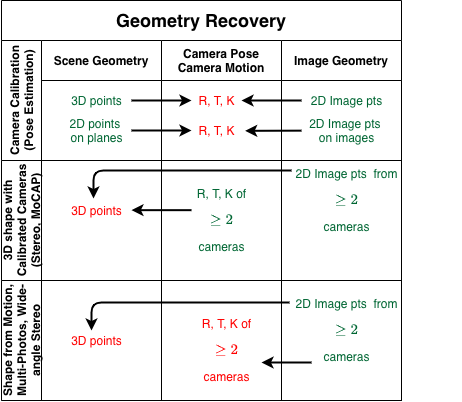

# 3D structure from multiple 2D views

* We will study the mathematics behind the recovery of 3D depth from multiple 2D images, *given the knowledge of intrinsic and extrinsic camera parameters*.

* We will assume that we know the correspondences between 2D points for which we want to estimate the 3D locations.

* We can set up the estimation problem in two different ways.

>> 1. Triangulation error (3D residual): This error measures the distance between the estimated 3D point and the two or more camera centers that observed the point correspondences. The triangulation error is minimized by adjusting the 3D point coordinates such that the distance between the estimated 3D point and the camera centers is minimized.

>> 2. Reprojection error (2D residual): This error measures the difference between the observed 2D point in the image and the projection of the corresponding 3D point onto the image plane. The reprojection error is minimized by adjusting the 3D point coordinates such that the projected 2D points in the image plane match the observed 2D points as closely as possible.

* Some applications

>> 1. Multi-view camera scene observations. ([The WILDTRACK Seven-Camera HD Dataset](https://www.epfl.ch/labs/cvlab/data/data-wildtrack/))

>> 2. Virtual reality simulators, e.g. [Computer Assisted Rehabilitation Environment System (CAREN)](https://www.youtube.com/watch?v=a6Quza3WmVA))

>> 3. Motion Capture Studio ([MoCap Studio](https://www.moves.com/))

Setup of a motion capture studio. Taken from https://www.youtube.com/watch?v=XIw9cZ8i4mE

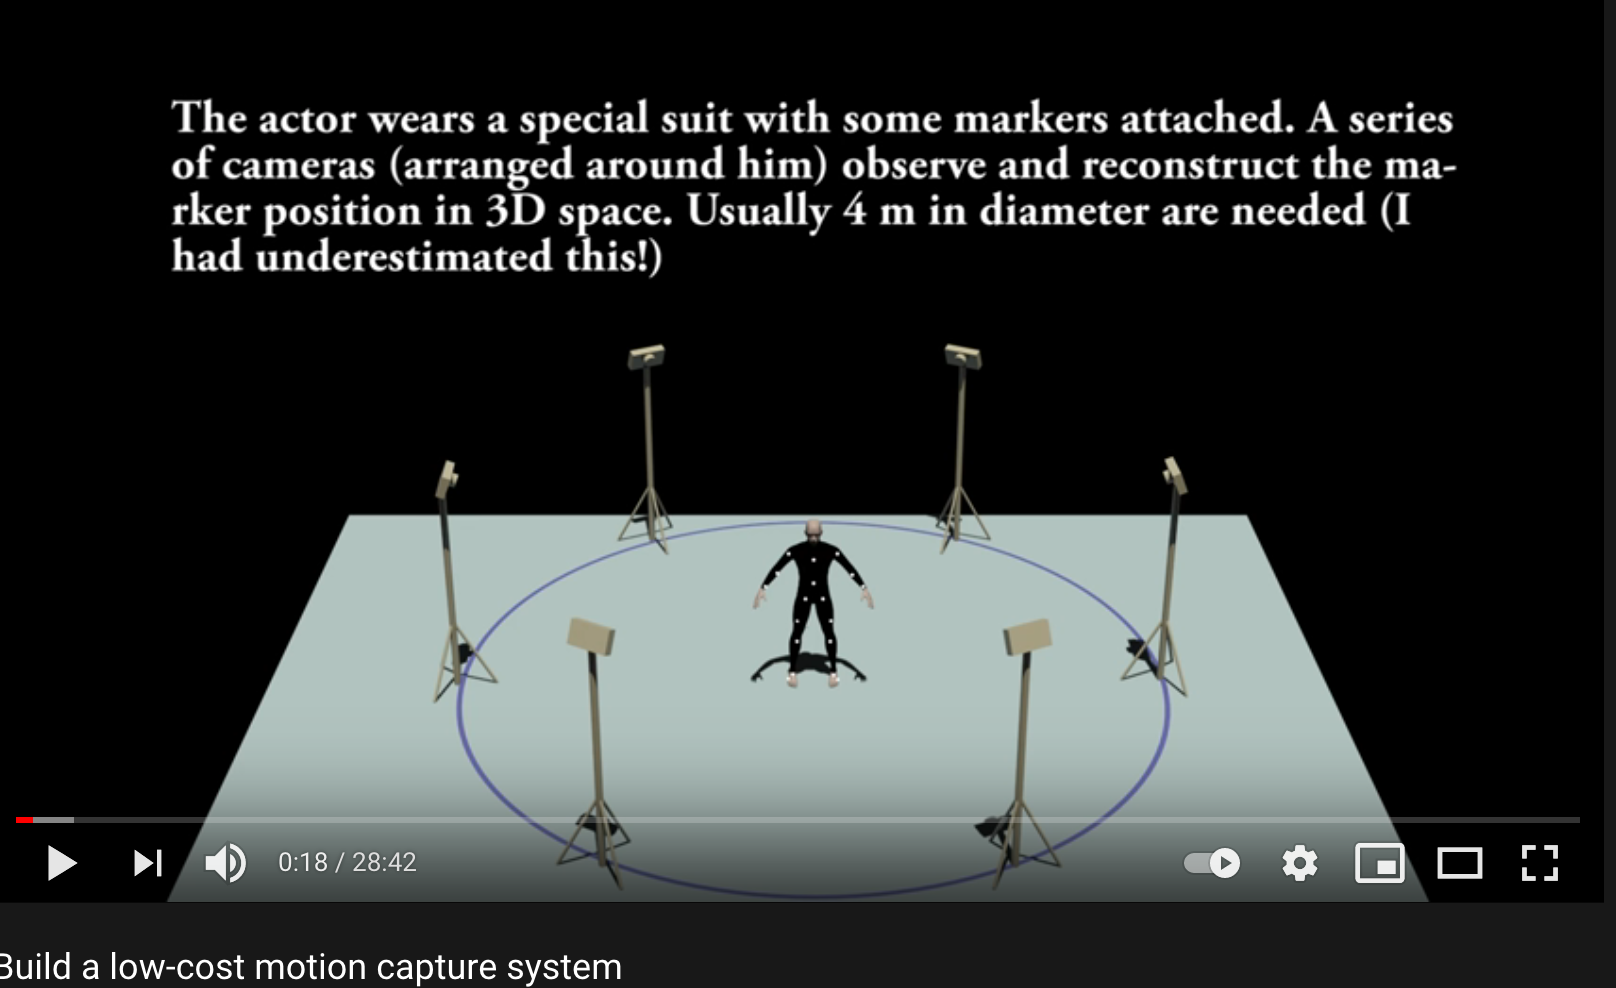

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.ndimage as scimage
from scipy.spatial.transform import Rotation
from skimage.transform import warp
from skimage import io

!pip install opencv-contrib-python==4.4.0.46
import cv2
print (cv2 .__version__)

!pip install xmltodict
import xmltodict

np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.8/148.8 MB 4.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
4.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'

Mounted at /content/drive


# Method 1: Minimize 3D residuals (errors)

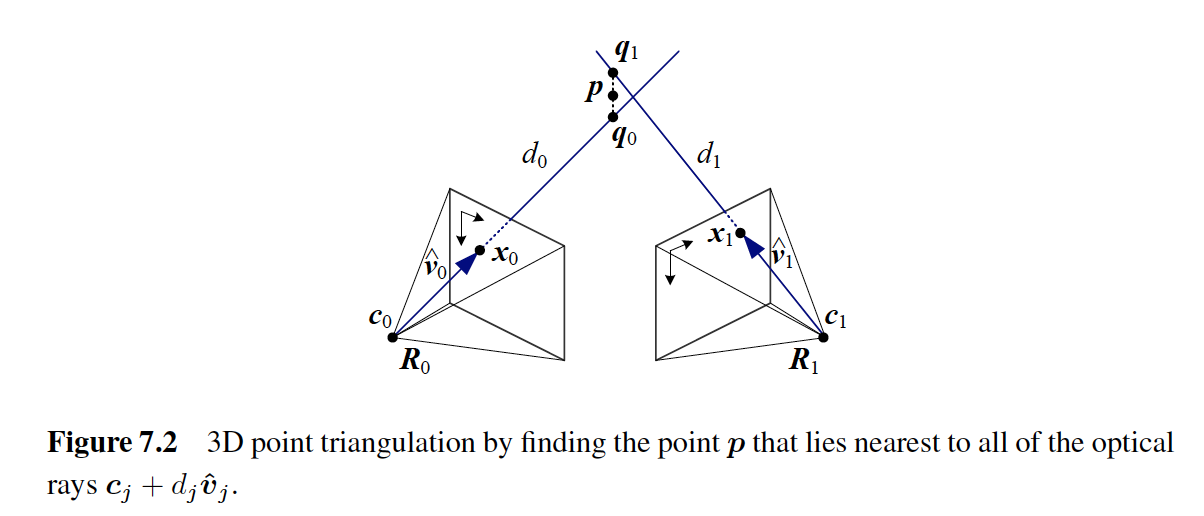

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

# Image coordinates in terms of 3D point location (in world coordinates)

* Assume calibrated cameras. Lens distortion has been removed. Use Fig 7.2 as illustration.

* We know that the homogeneous coordinate of an image pixel $(x_j, y_j)$ is related the 3D coordinates, which is unknown.

* **We assume that we have estimates of the intrinsic and extrinsic parameters.**
    


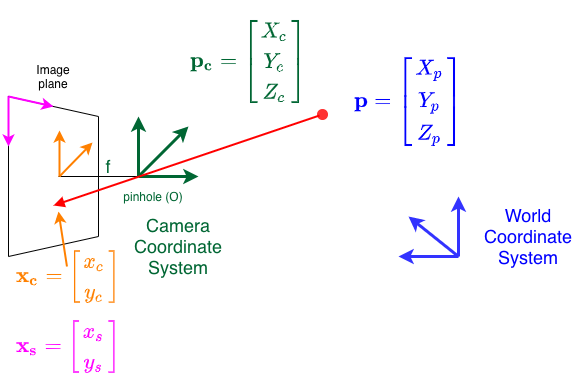

# Perspective camera model -- Ray through an image pixel

* Recall, the perspective camera model that relates the image location $(x_s, y_s)$ with the 3D location $(X_p, Y_p, Z_p)$.

\begin{eqnarray}
 \mathbf{\tilde{x}}_c = \begin{bmatrix}
    x_1 \\ x_2 \\ x_3
    \end{bmatrix} & = &
    \begin{bmatrix}
    -f & 0 & c_x  & 0 \\
    0 & -af  & c_y & 0 \\
    0 & 0 & 1 & 0
    \end{bmatrix}
    \begin{bmatrix}
    r_{00} & r_{01} & r_{02} & t_x \\
    r_{10} & r_{11} & r_{12}  & t_y  \\
    r_{20} & r_{21} & r_{22} & t_z \\
    0 & 0 & 0  & 1
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ Z_p\\1
    \end{bmatrix} \\
    & = &
    \begin{bmatrix}
    -f & 0 & c_x \\
    0 & -af  & c_y \\
    0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
    r_{00} & r_{01} & r_{02} & t_x \\
    r_{10} & r_{11} & r_{12}  & t_y  \\
    r_{20} & r_{21} & r_{22} & t_z
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ Z_p \\ 1
    \end{bmatrix} \\
    \mathbf{\tilde{x}}_c & = & \mathbf{K} \begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix} \mathbf{\tilde{p}} \\ \\
\begin{bmatrix} x_s \\  y_s \end{bmatrix}
& = &
\begin{bmatrix}
\frac{x_1}{x_3} \\
\frac{x_2}{x_3}
\end{bmatrix}
\end{eqnarray}




* The coordinates of the 3D point with respect to the camera, ignoring the intrinsic parameters, is given by:

    \begin{equation}
    \mathbf{p}_c  =  \begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix} \mathbf{\tilde{p}}
    \end{equation}

* It is worthwhile noting that $\mathbf{p}_c$ represents the ray from the camera center to the pixel and out to the 3D point, with respect to the **local** camera coordinates.

* While we cannot get these 3D coordinates from the 2D image coordinates, we can get the **vector** through the 3D point if we knew the instrinsic parameters.

    \begin{eqnarray}
    \mathbf{\tilde{x}}_c & = & \mathbf{K} \mathbf{p}_c \\
    \mathbf{p}_c & = & \mathbf{K}^{-1} \mathbf{\tilde{x}}_c \\
      & \propto  & \mathbf{K}^{-1} \begin{bmatrix} x_s \\  y_s \\ 1 \end{bmatrix}
    \end{eqnarray}
because
    \begin{eqnarray}
    \mathbf{\tilde{x}}_c & \propto & \begin{bmatrix} x_s \\  y_s \\ 1 \end{bmatrix} \\
    \end{eqnarray}


* Given the image location, the vector *towards* the 3D points, which we will denote by $\mathbf{\hat{x}}_c$, is given by the following expression. Of course, we do not know how far along this vector the 3D point lies!

\begin{equation}
\mathbf{\hat{x}}_c = \mathbf{K}^{-1} \begin{bmatrix} x_s \\  y_s \\ 1 \end{bmatrix}
\end{equation}


# Expressing the 3D world coordinate of a point as a function of the image coordinates.
Let the image of the 3D point $\mathbf{p} = (X_p, Y_p, Z_p )$ be denoted by $\mathbf{x_j}$ in the $j$-th camera. The intrinsic and extrinsic parameters of the $j$-th camera are denoted by $\mathbf{K}_j$, $\mathbf{R}_j$, and $\mathbf{t}_j$,
    
\begin{eqnarray}
\mathbf{\tilde{x}_j} & = & \mathbf{K}_j
\begin{bmatrix} \mathbf{R}_j & \mathbf{t}_j \end{bmatrix} \mathbf{\tilde{p}} \\
\mathbf{K}_j^{-1} \mathbf{\tilde{x}_j} & =  &
\begin{bmatrix} \mathbf{R}_j & \mathbf{t}_j \end{bmatrix} \mathbf{\tilde{p}}
\\
\mathbf{R}_j^T \mathbf{K}_j^{-1} \mathbf{\tilde{x}_j} & = &
\begin{bmatrix} \mathbf{I} & \mathbf{R}_j^T \mathbf{t}_j \end{bmatrix} \mathbf{\tilde{\tilde{p}}} \\
& = &
\begin{bmatrix}
1 & 0 & 0 & (\mathbf{R}_j^T \mathbf{t}_j)[0] \\
0 & 1 & 0 & (\mathbf{R}_j^T \mathbf{t}_j)[1] \\
0 & 0 & 1 & (\mathbf{R}_j^T \mathbf{t}_j)[2] \\
 \end{bmatrix}
\begin{bmatrix}
    X_p \\ Y_p \\ Z_p \\1
    \end{bmatrix} \\
& = &    
\begin{bmatrix}
X_p +  (\mathbf{R}_j^T \mathbf{t}_j)[0] \\
Y_p +  (\mathbf{R}_j^T \mathbf{t}_j)[1] \\
Z_p +  (\mathbf{R}_j^T \mathbf{t}_j)[2] \\
 \end{bmatrix} \\
\mathbf{R}_j^T \mathbf{K}_j^{-1} \mathbf{\tilde{x}_j} & = &
\mathbf{p} + \mathbf{R}_j^T \mathbf{t}_j
\end{eqnarray}


$\mathbf{c}_j = - \mathbf{R}_j^T \mathbf{t}_j$ is the vector from the world coordinate origin to the camera coordinate origin, specified with respect to the **world** coordinates. Note $\mathbf{t}_j$ is the vector pointing the other way, i.e. from camera origin to world origin, but specified with respect to the **camera** coordinates.

Using the above, we can rewrite the world coordinates as
    
\begin{equation}
    \mathbf{p} =  \mathbf{R}_j^T \mathbf{K}_j^{-1} \mathbf{\tilde{x}_j}  + \mathbf{c}_j
\end{equation}

Please keep in mind that $\mathbf{p}$ is specified with respect to the world coordinates.
    
It appears that we have a closed form solution for the 3D location of the image point just from one equation, but that is not so! In the above equation, we have to specify the homogeneous coordinates of the image pixel location, $\mathbf{\tilde{x}_j}  = \begin{bmatrix} w_j x_j \\ w_j y_j \\ w_j   \end{bmatrix}^T$. We know $(x_j, y_j)$, the pixel location, but we do not know $w_j$. The point could be anywhere along the vector that start from the image coordinate origin and go through the image pixel $(x_j, y_j)$. Refer to Figure 7.2 in the textbook.

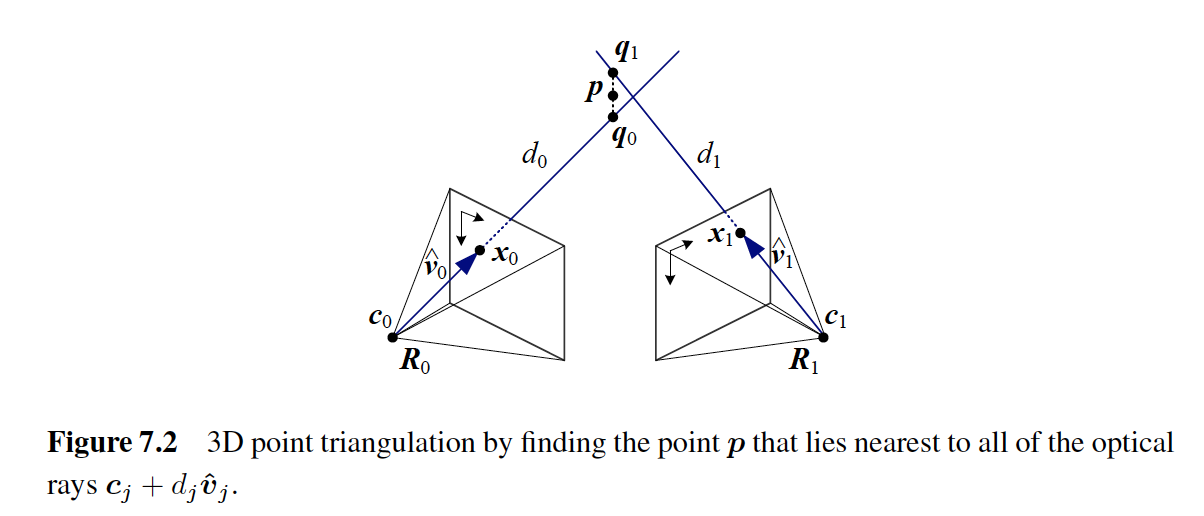

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

# 3D vector on which the 3D point lies for the $j$-th camera (expressed in world coordinates)

Re-writing the above equation using a compact notation.
    
\begin{equation}
    \mathbf{p}  =  \mathbf{R}_j^T \mathbf{K}_j^{-1} \begin{bmatrix} w_j x_j \\ w_j y_j \\ w_j   \end{bmatrix}  + \mathbf{c}_j
\end{equation}
    
\begin{equation}
    \mathbf{p}  =  w_j  \mathbf{R}_j^T \mathbf{K}_j^{-1} \begin{bmatrix} x_j \\ y_j \\ 1   \end{bmatrix}  + \mathbf{c}_j
\end{equation}
    
\begin{equation}
  \mathbf{p}  =  d_j  \mathbf{\hat{v}}_j \ + \mathbf{c}_j
\end{equation}
    
where $\mathbf{\hat{v}}_j$ is the normalized unit vector, along $\mathbf{R}_j^T \mathbf{K}_j^{-1} \begin{bmatrix} x_j \\ y_j \\ 1   \end{bmatrix}$, representing the vector through the image pixel, with respect to the **world** coordinates. We denote it by
    
\begin{equation}
\mathbf{\hat{v}}_j = \mathcal{N}(\mathbf{R}_j^T \mathbf{K}_j^{-1} \mathbf{x}_j)
\end{equation}

# The residual (error) of $j$-th point

The residual vector $\mathbf{r}_j$ is the given by
    
\begin{eqnarray}
    \mathbf{r}_j  & = & (d_j  \mathbf{\hat{v}}_j + \mathbf{c}_j) - \mathbf{p} \\
    & = & d_j  \mathbf{\hat{v}}_j  - (\mathbf{p}  - \mathbf{c}_j)
\end{eqnarray}
    
This is the vector connecting the lines through the image pixel and the vector to the 3D world coordinate, with respect to the **camera** coordinates, which is $(\mathbf{p}  - \mathbf{c}_j)$. Use Figure 7.2 to illustrate this.
    
The total residual over N-cameras is given by
    
\begin{equation}
    \sum_{j=1}^N ||{\mathbf{r}_j}||^2  = \sum_{j=1}^N  (d_j  \mathbf{\hat{v}}_j  - (\mathbf{p}  - \mathbf{c}_j))^T (d_j  \mathbf{\hat{v}}_j  - (\mathbf{p}  - \mathbf{c}_j))
\end{equation}

There are (N+3) unknowns: distances with respect to the $N$ cameras $d_j$'s, and the three world coordinates in $\mathbf{p}$.

# Minimize the total residual.

The unknowns are the depths from each of the cameras, $d_j$'s, and the coordinate of the 3D point, $\mathbf{p}$. We will derive the minimization conditions in two steps.

1. First, we will take derivative of the total residual with respect to $d_j$ and set it to zero.
    
\begin{eqnarray}
\frac{\partial}{\partial d_j} (d_j  \mathbf{\hat{v}}_j  + \mathbf{c}_j  - \mathbf{p})^T (d_j  \mathbf{\hat{v}}_j  + \mathbf{c}_j  - \mathbf{p}) & = &  0 \\
2 (\mathbf{\hat{v}}_j)^T (d_j  \mathbf{\hat{v}}_j \ + \mathbf{c}_j  - \mathbf{p})
& = &  0 \\
d_j + \mathbf{\hat{v}}_j^T (\mathbf{c}_j  - \mathbf{p})
& = &  0 \\
d_j & = &  \mathbf{\hat{v}}_j^T (\mathbf{p} - \mathbf{c}_j)
\end{eqnarray}

>> Use Figure 7.2 in the textbook to trace out the geometry of the above equation.

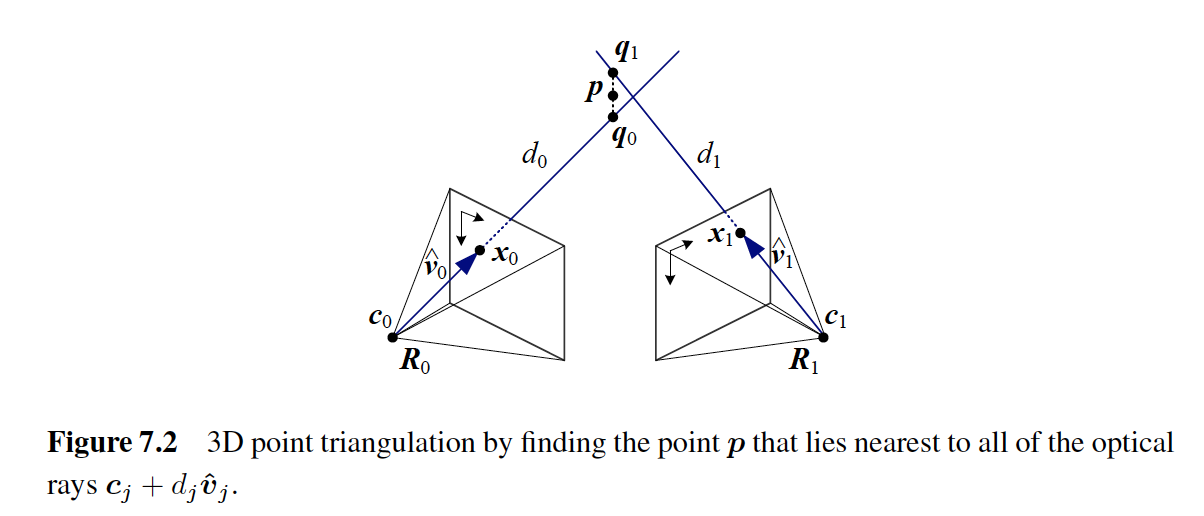

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

>> Plugging this back into the residual equation, we have a new expression of the residual that does not involve $d_j$.

\begin{eqnarray}
     \sum_{j=1}^N || \mathbf{r}_j||^2  & = & \sum_{j=1}^N  || ( \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T (\mathbf{p} - \mathbf{c}_j) \ - (\mathbf{p}  - \mathbf{c}_j))||^2
     \\
       & = & \sum_{j=1}^N  ( (\mathbf{I} - \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T) (\mathbf{p} - \mathbf{c}_j))^T
     ( (\mathbf{I} - \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T) (\mathbf{p} - \mathbf{c}_j))
      \\
\end{eqnarray}

2. Second, we take the derivative of the above residual expression with respect to $\mathbf{p}$ and set it to zero.

\begin{eqnarray}
     \sum_{j=1}^N  ( \mathbf{I} - \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T)^T
     ( (\mathbf{I} - \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T) (\mathbf{p} - \mathbf{c}_j)) & = 0
      \\
      \sum_{j=1}^N  ( \mathbf{I} - \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T)
     (\mathbf{I} - \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T) (\mathbf{p} - \mathbf{c}_j) & = 0
      \\
      \sum_{j=1}^N  ( \mathbf{I} - 2 \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T
      + \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T)
     (\mathbf{p} - \mathbf{c}_j) & = 0
      \\
      \sum_{j=1}^N  ( \mathbf{I} -  \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T)
     (\mathbf{p} - \mathbf{c}_j) & = 0
      \\
      \\
      \left ( \sum_{j=1}^N  ( \mathbf{I} -  \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T) \right )
     \mathbf{p} - \sum_{j=1}^N  ( \mathbf{I} -  \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T)  \mathbf{c}_j  & = 0
      \end{eqnarray}
    

# The solution (in closed form)

The least square estimate of the 3D location of the point is given by
\begin{equation}
\mathbf{p} = \left ( \sum_{j=1}^N  ( \mathbf{I} -  \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T) \right )^{-1}
\sum_{j=1}^N  ( \mathbf{I} -  \mathbf{\hat{v}}_j \mathbf{\hat{v}}_j^T)  \mathbf{c}_j  
\end{equation}

**This equation is valid only when we have more than one camera.** For one camera, we get a degenerate solution where $\mathbf{p} = \mathbf{c}_j$, i.e. the point is located at the camera origin!


## Code: `estimate_3D_pt_3D_residual`

In [3]:
def estimate_3D_pt_3D_residual (pts, K, R, T) :
    ''' K, R, T: lists of size N of intrinsic and extrinsic parameters of the cameras.
        pts: 2 by N point locations on image
        returns 3 by 1 location of the 3D point.'''
    N = pts.shape[1]
    denominator = np.zeros((3,3))
    numerator = np.zeros((3,1))
    v = np.ones((3,1))
    for j in range (N) :
        v[0] = pts[0,j]; v[1] = pts[1,j];
        v_hat = np.linalg.inv(K[j] @ R[j]) @ v
        v_hat = v_hat / np.linalg.norm(v_hat, axis=0)
        #print('v_hat', v_hat)
        c_j = - np.transpose(R[j]) @ T[j]
        #print('c_j', c_j)
        denominator += (np.eye(3) - v_hat @ np.transpose(v_hat))
        numerator += (np.eye(3) - v_hat @ np.transpose(v_hat)) @ c_j

    p = np.linalg.inv(denominator) @ numerator
    return(p)

# Example: WILDTRACK dataset

"[WILDTRACK: A Multi-Camera HD Dataset for Dense Unscpted Pedestrian Detection](https://openaccess.thecvf.com/content_cvpr_2018/html/Chavdarova_WILDTRACK_A_Multi-Camera_CVPR_2018_paper.html)," Tatjana Chavdarova, Pierre Baqué, Stéphane Bouquet, Andrii Maksai, Cijo Jose, Timur Bagautdinov, Louis Lettry, Pascal Fua, Luc Van Gool, François Fleuret; Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2018, pp. 5030-5039

The full dataset is available at https://www.epfl.ch/labs/cvlab/data/data-wildtrack/


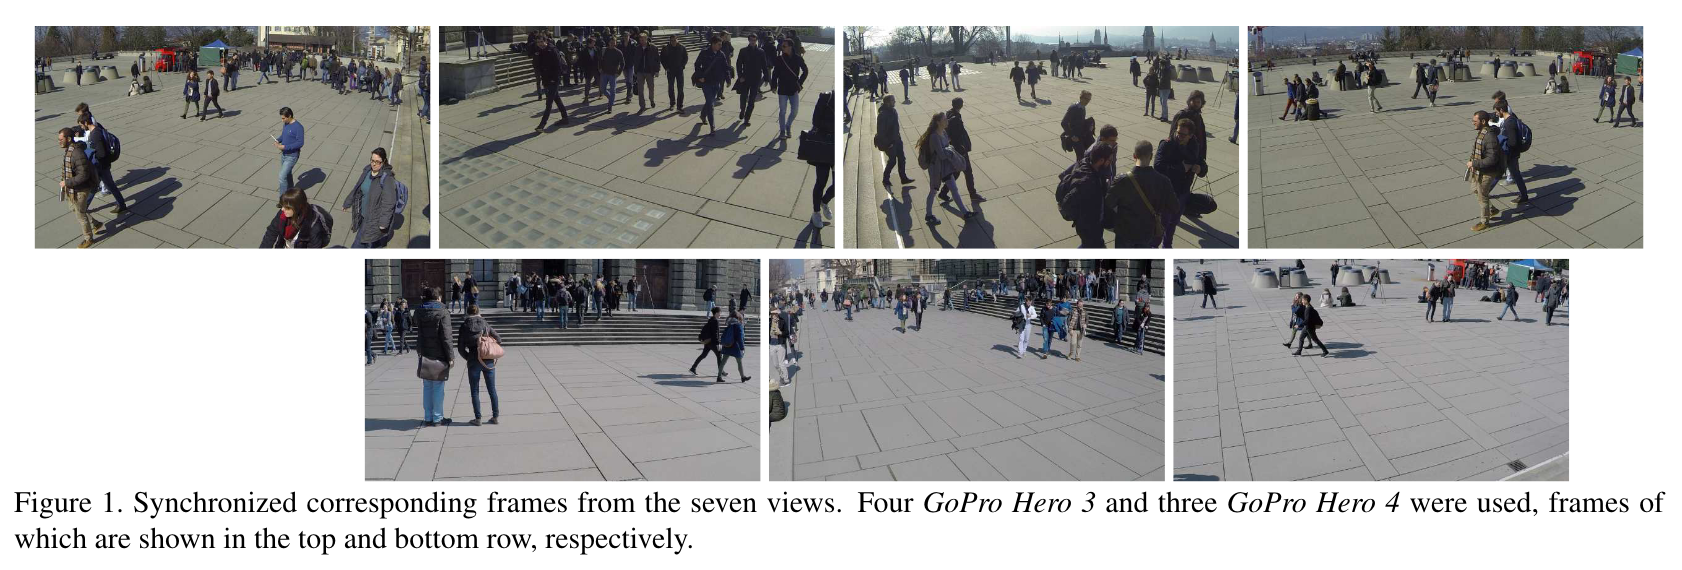

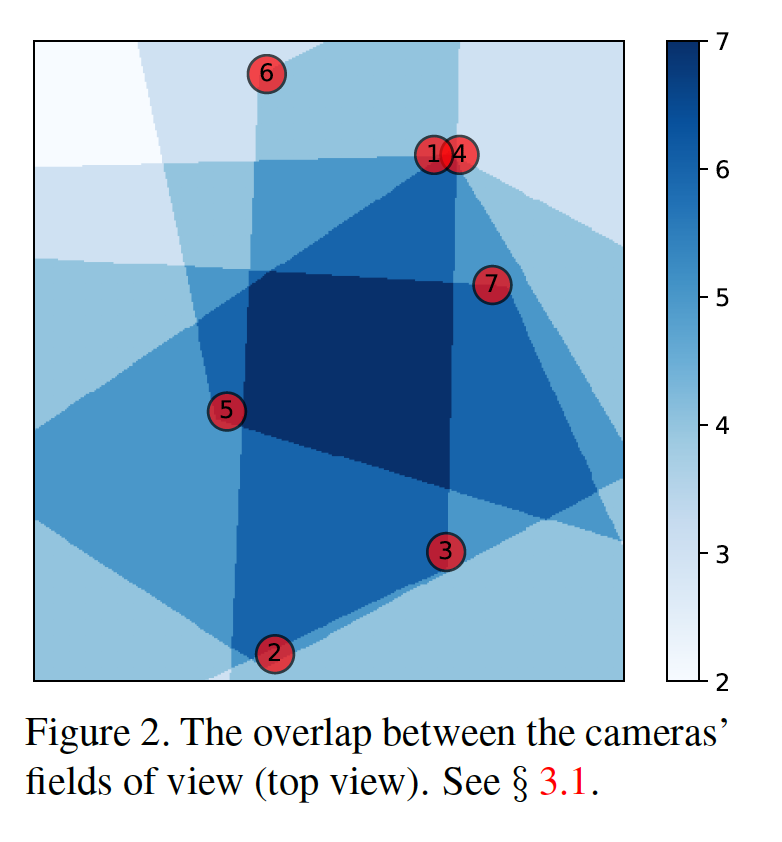

## Code: Read camera calibration data

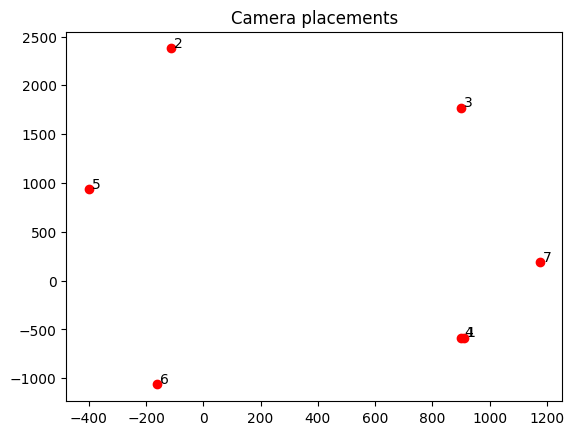

In [5]:
# Read calibration data
calib_dir = data_dir+'Wildtrack/calibrations/'
extrinsic_calibration_files = ['extrinsic/extr_CVLab1.xml', 'extrinsic/extr_CVLab2.xml', 'extrinsic/extr_CVLab3.xml',
                               'extrinsic/extr_CVLab4.xml', 'extrinsic/extr_IDIAP1.xml', 'extrinsic/extr_IDIAP2.xml',
                               'extrinsic/extr_IDIAP3.xml']
intrinsic_calibration_files = ['intrinsic_zero/intr_CVLab1.xml', 'intrinsic_zero/intr_CVLab2.xml', 'intrinsic_zero/intr_CVLab3.xml',
                               'intrinsic_zero/intr_CVLab4.xml', 'intrinsic_zero/intr_IDIAP1.xml', 'intrinsic_zero/intr_IDIAP2.xml',
                               'intrinsic_zero/intr_IDIAP3.xml']
R_list = [] # list of rotations
T_list = [] # list of translations
K_list = [] # list of intrinsic parameters
c_list = [] # list of camera locations w.r.t world coordinates
for i in range(7) :
    #read extrinsic parameters
    extr_file = calib_dir + extrinsic_calibration_files[i]
    xml_data = open(extr_file, 'r').read()  # Read data
    xmlDict = xmltodict.parse(xml_data)  # Parse XML
    rot_rodriges = np.fromstring(xmlDict['opencv_storage']['rvec'], sep=' ')
    R = Rotation.from_rotvec(rot_rodriges).as_matrix()
    R_list.append(R)
    T = np.fromstring(xmlDict['opencv_storage']['tvec'], sep=' ')
    T_list.append(T[:,None]) # make it a (3, 1) dimensional matrix -- intead of a (3,) sized vector
    c_list.append(-np.transpose(R_list[i]) @ T_list[i])
    plt.title('Camera placements')
    plt.plot(c_list[i][0], c_list[i][1], 'ro')
    plt.text(c_list[i][0]+10, c_list[i][1]+10, '{}'.format(i+1))

    # read intrinsic parameters
    intr_file = calib_dir + intrinsic_calibration_files[i]
    xml_data = open(intr_file, 'r').read()  # Read data
    xmlDict = xmltodict.parse(xml_data)  # Parse XML
    K_mat = np.fromstring(xmlDict['opencv_storage']['camera_matrix']['data'], sep=' ').reshape(3,3)
    K_list.append(K_mat)

#print('Rotation matrices=\n', R_list)
#print('Translation vectors=\n', T_list)
#print('Intrnsic matrices=\n', K_list)
#print('Camera centers=\n', c_list)

# Form P array of N_cameras by 3 by 4
N = len(R_list)
P_mat = np.zeros((N, 3, 4))
for j in range(N) :
    P_mat[j,:,:] = K_list[j] @ np.column_stack((R_list[j], T_list[j]))

#print ('Projective matrices =\n', P_mat)


## Code: Helper code

In [6]:
def world_to_image (p, K, R, T) :
    # p is a 3D point, return the 2D image location
    x = K @ (R @ p + T)
    x /= x[2,:]
    return(x[0:2,:])

In [7]:
def inside_image (image, p) :
    # p is 2 by N set of points, return N, size array indicating which points are inside the image.
    insideP = (p[1,:] < image.shape[0]) * (p[0,:] < image.shape[1]) * (p[0,:] > 0) * (p[1,:] > 0)
    return(insideP)

## Code: Test estimation using made-up 3D data but real cameras




In [8]:
# Made-up test -- 3D residual based estimates

# pick a 3D world point
world_pt = np.array([[2000], [-1000], [1000]])

# project the 3D point into the 7 camera images
im_pt = np.zeros((2, 7))
noise_amp = 10 #pixels
for i in range (7) :
    im_p = world_to_image (world_pt, K_list[i], R_list[i], T_list[i])
    im_p = im_p + noise_amp*(np.random.rand(2,1)-0.5)
    im_pt[:,i] = im_p.squeeze()

# Estimate 3D points using all cameras
print('Estimate using all cameras')
estimated_world_pt = estimate_3D_pt_3D_residual (im_pt, K_list, R_list, T_list)
print('Original point coord in 3D', world_pt.transpose())  # transposing just for display purposes
print(' 2D image location error: {:2d} pixels'.format(noise_amp))
print('Estimated point coord in 3D:', estimated_world_pt.transpose()) # transposing just for display purposes

# Estimate 3D points using selected cameras
selected_list = [0, 2, 4]
K_list_selected = [K_list[i] for i in selected_list]
R_list_selected = [R_list[i] for i in selected_list]
T_list_selected = [T_list[i] for i in selected_list]

print('\n\nEstimate using a subset of cameras:', selected_list)
estimated_world_pt = estimate_3D_pt_3D_residual (im_pt[:, selected_list], K_list_selected, R_list_selected, T_list_selected)
print('Estimated point coord in 3D: ', estimated_world_pt.transpose()) # transposing just for display purposes



Estimate using all cameras
Original point coord in 3D [[ 2000 -1000  1000]]
 2D image location error: 10 pixels
Estimated point coord in 3D: [[ 2000.18 -1001.2   1001.93]]


Estimate using a subset of cameras: [0, 2, 4]
Estimated point coord in 3D:  [[ 2001.8  -1003.26  1004.14]]


## Code: 3D estimation in real images -- WILDTRACK dataset

In [19]:
shoe_tip = np.array([[831, 401], [0, 0], [967, 346], [1882, 432], [1650, 580], [620, 335], [765, 398]])
images = []
P = []
# fig, ax = plt.subplots(7, 1)
# fig.set_size_inches(20, 60)

# Estimate 3D points using selected cameras
select_combos = [[0, 2], [0, 3], [0, 4], [0, 5], [0, 6],
                 [2, 3], [2, 4], [2, 5], [2, 6],
                 [3, 4], [3, 5], [3, 6],
                 [4, 5], [4, 6],
                 [5, 6]]

print(len(select_combos))

for selected_list in select_combos:
    K_list_selected = [K_list[i] for i in selected_list]
    R_list_selected = [R_list[i] for i in selected_list]
    T_list_selected = [T_list[i] for i in selected_list]

    shoe_tip_3D = estimate_3D_pt_3D_residual (np.transpose(shoe_tip)[:,selected_list],
                                              K_list_selected, R_list_selected, T_list_selected)

    print(f'Using cameras {selected_list[0]} and {selected_list[1]}')
    print('3D shoe tip location: ', shoe_tip_3D)

    reprojected_error = 0.0
    count = 0
    for i in range(7) :
        file_name = data_dir+'Wildtrack/C{:1d}/00000015.png'.format(i+1)
        image = io.imread(file_name)
        images.append(image)

        #ax[i].imshow(images[i], 'gray')
        if (i in selected_list): #images selected to create the estimate
            #ax[i].plot(shoe_tip[i, 0], shoe_tip[i, 1], 'go')
            # plot the ground truth the shoe tip in green for images selected to create the estimate
            continue
        else: #images NOT selected to create the estimate
          #ax[i].plot(shoe_tip[i, 0], shoe_tip[i, 1], 'ro')
          x_shoe = world_to_image (shoe_tip_3D, K_list[i], R_list[i], T_list[i]) # reproject on image
          #ax[i].plot(x_shoe[0], x_shoe[1], 'bx') # plot reprjected shoe tip

          # compute reprojected error
          if (i != 1) : # ignore camera 2 for which we do not have shoe tip location
              error = np.linalg.norm(x_shoe.squeeze () - shoe_tip[i,:])
              reprojected_error  = reprojected_error + error
              count = count + 1
              print('\n Camera {} reprojected shoe tip at {}, actual shoe tip at {}, error: {:3.2f} pixels'.format(i, x_shoe.squeeze(), shoe_tip[i,:].transpose(), error))

    print('\n\nAverage reprojected error: {:3.2f} pixels'.format(reprojected_error/count))


15
Using cameras 0 and 2
3D shoe tip location:  [[242.02]
 [494.02]
 [ 13.97]]

 Camera 3 reprojected shoe tip at [1885.    428.14], actual shoe tip at [1882  432], error: 4.89 pixels

 Camera 4 reprojected shoe tip at [1644.79  575.49], actual shoe tip at [1650  580], error: 6.89 pixels

 Camera 5 reprojected shoe tip at [620.47 324.15], actual shoe tip at [620 335], error: 10.86 pixels

 Camera 6 reprojected shoe tip at [763.79 398.47], actual shoe tip at [765 398], error: 1.30 pixels


Average reprojected error: 5.99 pixels
Using cameras 0 and 3
3D shoe tip location:  [[ 22.61]
 [848.99]
 [-76.16]]

 Camera 2 reprojected shoe tip at [1469.73  501.04], actual shoe tip at [967 346], error: 526.09 pixels

 Camera 4 reprojected shoe tip at [ 935.82 1126.48], actual shoe tip at [1650  580], error: 899.27 pixels

 Camera 5 reprojected shoe tip at [324.96 379.44], actual shoe tip at [620 335], error: 298.37 pixels

 Camera 6 reprojected shoe tip at [1101.86  385.98], actual shoe tip at [76

# Assignment -- Which pair of cameras gives us the best estimate of the 3D?

Consider all pairs of camera from the pool of 6 cameras. Ignore camera 2 for which we do not have a shoe tip location estimate. There are 15 pairs (6 choose 2 combinations).

Which pair of cameras gives us the best 3D coordinate estimate, as quantified by the error in the projected coordinates? Explain why?

Which pair gives us the worst estimate? Explain why?



# Method 2: Minimize 2D residuals on the image

Minimizing 2D residuals can produce significantly better estimates if many of the cameras are closer to the 3D points than others, i.e. the points are distributed widely in 3D space.

1. Write the 3D to 2D projective equations for the two cameras using the $\mathbf{P}$ matrix.

2. What are the known and the unknowns?

3. Write the expression for the residual to be minimized.

4. Since the residual is non-linear with respect to the unknowns, we have to adopt non-linear least square estimation strategy. Given the parameters at iteration $k$, $ \mathbf{p}(k)$, we have to add $\Delta \mathbf{p}$ to it so that the residual is minimized. Write the expression of the residual as a function of  $\Delta \mathbf{p}$ using the Taylor series expansion.
    
5. Write the expression for the Jacobian.
    
6. What is the linear equation that will be solved at each step in terms of the Hessian?
    
7. What is the rank of Hessian? What is the minimum number of cameras you would need?
    
8. How can you initialize the whole process? Write the DLT form of the estimation problem.
    
9. What are the different options for solving the DLT form? Which one would you prefer?
    

1. Write the 3D to 2D projective equations for the two cameras using the $\mathbf{P}$ matrix.

\begin{eqnarray}
    \mathbf{\tilde{x}_j} = \mathbf{K}_j
    \begin{bmatrix} \mathbf{R}_j & \mathbf{t}_j \end{bmatrix} \mathbf{\tilde{p}} = \mathbf{P}_j \mathbf{\tilde{p}} & = &
    \begin{bmatrix}
    p^j_{00} & p^j_{01} & p^j_{02} & p^j_{03} \\
    p^j_{10} & p^j_{11} & p^j_{12} & p^j_{13} \\
    p^j_{20} & p^j_{21} & p^j_{22} & p^j_{23} \\
    \end{bmatrix}
    \begin{bmatrix}
    X \\ Y \\ Z \\ 1
    \end{bmatrix}\\
    x_j = f_x(\mathbf{P}^j; \mathbf{p}) & = &
    \frac{p^j_{00} X  + p^j_{01} Y +  p^j_{02} Z + p^j_{03}}
    {p^j_{20} X  + p^j_{21} Y +  p^j_{22} Z + p^j_{23}} \\
    y_j = f_y(\mathbf{P}^j; \mathbf{p}) & = &
    \frac{p^j_{10} X  + p^j_{11} Y +  p^j_{12} Z + p^j_{13}}
    {p^j_{20} X  + p^j_{21} Y +  p^j_{22} Z + p^j_{23}}
\end{eqnarray}




2. What are the known and the unknowns?

>> Here the entries of the projection matrix are known and the homogeneous coordinates of the 3D point are unknown.

2. Write the expression for the residual to be minimized.

>> The total residual, which is a function of the 3D point coordinates with respect to the world, is given by

\begin{eqnarray}
    r_{total}(\mathbf{p}) & = & \sum_{j=1}^{N}
    ||\mathbf{x}_j - \mathbf{f}(\mathbf{P}^j; \mathbf{p})||^2 \\
\end{eqnarray}

>> The unknown is the vector $\mathbf{p} = \begin{bmatrix} X\\Y\\Z \end{bmatrix}$.


4. Since the residual is non-linear with respect to the unknowns, we have to adopt non-linear least square estimation strategy. Given the parameters at iteration $k$, $ \mathbf{p}(k)$, we have to add $\Delta \mathbf{p}$ to it so that the residual is minimized. Write the expression of the residual as a function of  $\Delta \mathbf{p}$ using the Taylor series expansion.
    
>> Let the estimate of this vector at iteration $k$ be denoted by $\mathbf{p}(k)$. Then we want to find a change in this vector, denoted by $\Delta \mathbf{p}(k)$ such that the residual with $\mathbf{p} (k+1) = \mathbf{p}(k) + \Delta \mathbf{p} $ is minimized.
    
>> The total image residual for $N$ cameras is given by
    
\begin{eqnarray}
    E_{NLS}^{(k)}(\Delta \mathbf{p}) & = & \sum_{j=1}^{N}
    ||\mathbf{x}_j - \mathbf{f}(\mathbf{P}^j; \mathbf{p}(k) + \Delta \mathbf{p} )||^2 \\
& \approx & \sum_{j=1}^{N}
    ||\mathbf{x}_j - \mathbf{f}(\mathbf{P}^j; \mathbf{p}(k)) +
    \frac{\partial \mathbf{f}(\mathbf{P}^j; \mathbf{p} (k))}{\partial \mathbf{p}}  \Delta \mathbf{p}||^2 \\
& \approx & \sum_{j=1}^{N}
    ||\mathbf{J} (\mathbf{P}^j; \mathbf{p} (k))  \Delta \mathbf{p} - \mathbf{r}_j(k)||^2
\end{eqnarray}
    
>> where $\mathbf{J}$ is the Jacobian for the $k$-iteration and $\mathbf{r}_j(k)$is the residual at the $k$-iteration.

5. Write the expression for the Jacobian.
    
>> The Jacobian is 2 by 3 and are given by the entries
    
\begin{equation}
\mathbf{J}^j =
\begin{bmatrix}
\frac{\partial f_x}{\partial X} & \frac{\partial f_x}{\partial Y} &
\frac{\partial f_x}{\partial Z} \\
\frac{\partial f_y}{\partial X} & \frac{\partial f_y}{\partial Y} &
\frac{\partial f_y}{\partial Z} \\
\end{bmatrix}
\end{equation}
    
>>Let $D(k) = p^j_{20} X(k)  + p^j_{21} Y(k) +  p^j_{22} Z(k) + p^j_{23}$ be the denominator at  the $k$-th iteration.
    
\begin{eqnarray}
    \frac{\partial f_x}{\partial X} & = & \frac{1}{D(k)} (p_{00}^j - p^j_{20} x_j) \\
    \frac{\partial f_x}{\partial Y} & = & \frac{1}{D(k)} (p_{01}^j - p^j_{21} x_j) \\
    \frac{\partial f_x}{\partial Z} & = & \frac{1}{D(k)} (p_{02}^j - p^j_{22} x_j) \\
    \frac{\partial f_y}{\partial X} & = & \frac{1}{D(k)} (p_{10}^j - p^j_{20} y_j) \\
    \frac{\partial f_y}{\partial Y} & = & \frac{1}{D(k)} (p_{11}^j - p^j_{21} y_j) \\
    \frac{\partial f_y}{\partial Z} & = & \frac{1}{D(k)} (p_{12}^j - p^j_{22} y_j) \\
\end{eqnarray}
    

6. What is the linear equation that will be solved at each step in terms of the Hessian?

>> Solve the following linear equation
    
\begin{equation}
\mathbf{A} \Delta \mathbf{p} = \mathbf{b}
\end{equation}
    
>>>>>where $\mathbf{A}= \sum_j (\mathbf{J}^j)^T (\mathbf{J}^j)$ and $\mathbf{b} = \sum_j (\mathbf{J}^j)^T (r_j(k))$.

\begin{equation}
\mathbf{p} (k+1) = \mathbf{p}(k) + \Delta \mathbf{p}
\end{equation}

> Recompute Jacobian and then the next change in parameters. Repeat until change in residual is small.

7. What is the rank of Hessian? What is the minimum number of cameras you would need?

 * Unique solution exists only if the rank of the 3 by 3 Hessian $\mathbf{A}$ is 3.

 * Rank contribution from one camera $\text{Rank}((\mathbf{J}^j)^T (\mathbf{J}^j)) = 2$. Can you explain why?

 * $\text{Rank}(\mathbf{A}+\mathbf{B}) \le \text{Rank}(\mathbf{A})+ \text{Rank}(\mathbf{B})$.

 * So, we would need at least two cameras to infer the depth of one point. This is also what we expect from commonsense. It is impossible to infer depth one point just from one view.

8. How can you initialize the whole process? Write the DLT form of the estimation problem.

\begin{equation}
    \begin{bmatrix}
    \vdots & \vdots &\vdots &\vdots \\
    \vdots & \vdots &\vdots &\vdots \\
    (p_{20}^j x_j - p_{00}^j) & (p_{21}^j x_j - p_{01}^j) &
    (p_{22}^j x_j - p_{02}^j) & (p_{23}^j x_j - p_{03}^j)  \\
    (p_{20}^j y_j - p_{10}^j) & (p_{21}^j y_j - p_{11}^j) &
    (p_{22}^j y_j - p_{12}^j) & (p_{23}^j y_j - p_{13}^j)  \\
    \vdots & \vdots &\vdots &\vdots  \\
    \vdots & \vdots &\vdots &\vdots  \\
    \end{bmatrix}
    \begin{bmatrix}
X \\ Y \\ Z \\ W
\end{bmatrix} = 0
\end{equation}

## Code: `DLT_estimate_3D_pt_from_2D_pts`

In [ ]:
import scipy.sparse.linalg
def DLT_estimate_3D_pt_from_2D_pts (pts_2d, P) :
    ''' P: array size N by 3 by 4 of projective parameters of the N cameras.
        pts_2D: 2 by N point locations on image
        returns the DLT error and the 3 by 1 location of the 3D point.'''
    N = pts_2d.shape[1]
    A = np.zeros((2*N, 4))
    for j in range (N) :
        A[2*j,:]   = P[j,2,:] * pts_2d[0,j] - P[j,0,:]  # first row
        A[2*j+1,:] = P[j,2,:] * pts_2d[1,j] - P[j,1,:]  # second row

    vals, vecs = scipy.sparse.linalg.eigs(np.transpose(A) @ A, k=1, which='SM') # smallest eigenvalue
    print('Minimum singular value', np.real(vals[0]))

    p = np.real(vecs).squeeze()
    p /= p[3]
    return(np.real(vals[0]),  p[0:3])


9. What are the different options for solving the DLT form? Which one would you prefer?

> It is best if we keep the fourth components of homogeneous coordinate of the 3D point, $W$, as an unknown. (The other option is to fix W = 1 and rewrite thep problem in the form Ax = b, which can be solved using QR decomposition.)

Do SVD of the left side matrix and pick the vector corresponding to the smallest singular value as the estimate of the homogeneous coordinate. Normalize by the last element to obtain an estimate of the coordinates.

Computer the smallest eigenvalue of $\mathbf{A}^T \mathbf{A}$ and pick the corresponding eigenvector as the solution. This is faster to compute.

> To form this estimate, we need at least two cameras, which results in 4 rows in of the DLT matrix above to estimate the 4 unknowns.



## Code: Estimating 3D location by minimizing 2D image residuals


In [ ]:
import torch

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")  # Uncomment this to run on GPU
#-------------------------------------------------------------------------------
def estimate_3D_pt_2D_residual_Gauss_Newton (pts_2d, P) :
    ''' P: array size N by 3 by 4 of projective parameters of the N cameras.
        pts_2D: 2 by N point locations on image
        returns the DLT error and the 3 by 1 location of the 3D point.'''
    N_cameras = pts_2d.shape[1]
    P = torch.tensor(P, device = device, requires_grad=False) # perspective projection equation
    X_gt = torch.tensor(pts_2d, device = device, requires_grad=False) # non-homogenous coordinates
    h_one = torch.tensor([1], device = device, requires_grad=False) # fixed entry of the homogenous representation of a point

    def transform (X_3D): # just 3D vector representing the point
        ''' This function return the error we want to minimize by varying the input, i.e. the 3D coordinates
            It assumes that it has access to a global variable, P, which contains the projective parameters of
            each of the cameras. P is a three dimensional matrix. The first dimension of P is the camera id.
            The next two stores the 12 camera projective parameters of the respective camera. P[j, :, :] contains
            the 12 projective parameters of the j-th camera. The dimension of P is N_cameras by 3 by 4.'''

        X_h = torch.cat((X_3D, h_one), 0)
        xim_h = torch.matmul(P, X_h)  # Tensor sizes -- (N by 3 by 4) @ (4 by 1) = N by 3 by 1
        xim_h = xim_h.squeeze().transpose(1, 0) # from N by 3 by 1 to 3 by N
        xim_nh = non_homogeneous (xim_h) # Tensor sizes -- 3 by N reduced to 2 by N
        #print('X_h ', X_h.shape, 'xim_h', xim_h.shape, 'xim_nh', xim_nh.shape, 'X_gt', X_gt.shape)
        Xloss =  loss(xim_nh)
        return (Xloss)

    def non_homogeneous (X_in) :
        # X is a 3 by N matrix -- each column is a homogenenous coordinate of a point
        X_out = torch.div(X_in, X_in [2,:]) # normalized homogenous coordinates
        return(X_out [0:2,:])

    def loss (X_t) :
        # Note X_gt is not defined in this function scope
        return(X_gt - X_t)

    def SSD_fit_error (X_3D) :
        # Note X is not defined in this function scope
        Xt = transform (X_3D)
        return(torch.pow(Xt, 2).sum())

    # initialize the location estimate using DLT
    error_, X_DLT  = DLT_estimate_3D_pt_from_2D_pts (pts_2d, P)
    #X_DLT += 100*np.random.rand() # if you can want to experiment with adding noise to DLT estimates, you can uncomment this.
    print('Initialize with DLT estimate: \n', X_DLT)
    print('DLT "error"= ', error_)
    X_NLS = torch.tensor(X_DLT, device = device, requires_grad=True)

    change_in_residual = 1.0
    old_residual = torch.sqrt(SSD_fit_error(X_NLS)/N_cameras)
    print('Initial 2D image residual: {}'.format(old_residual))

    while change_in_residual > 0.001:
        'Compute Jacobian'
        J = - torch.autograd.functional.jacobian(transform, X_NLS) # do not understand this is off by a sign?!
        # print('Jacobian shape=', J.shape, '\n Jacobian = \n', J)
        # size of J is torch.Size([2, N_data, 3])
        JJ = J.permute(1, 0, 2)   # N_pts by 2 by 8
        J_T = J.permute(1, 2, 0) # N_pts by 8 by 2

        'Compute A -- Hessian'
        A = torch.sum((J_T @ JJ), 0)

        'Compute residual'
        del_r = transform(X_NLS)  # rise of del_r is torch.Size([2, N_data])
        del_r = del_r.permute(1, 0)[:,:,None]  #46 by 2 by 1
        #print('Shapes A {}, J {}, JT {}, delr {}'.format(A.shape, J.shape, J_T.shape, del_r.shape))

        'Compute b vector'
        b = torch.sum((J_T @ del_r), 0)
        #print('Jacobian=\n', J, 'A=\n', A, 'A2=\n', A2, 'b=\n', b)

        'Compute change in parameter'
        del_p = (torch.inverse(A) @ b).squeeze()

        'Update estimate'
        X_NLS  = X_NLS + del_p

        'Compute new residual and percentage change in residual'
        new_residual = torch.sqrt(SSD_fit_error(X_NLS)/N_cameras)
        change_in_residual = (old_residual - new_residual)/old_residual
        old_residual = new_residual

        print('Residual: {}'.format(new_residual))

    X_NLS = X_NLS.detach().cpu().numpy()
    X_NLS = X_NLS[:, None]
    return(new_residual, X_NLS)

## Code: 3D estimation in real images -- WILDTRACK dataset

Minimum singular value 574.0516982591389
Initialize with DLT estimate: 
 [240.36 493.56  10.01]
DLT "error"=  574.0516982591389
Initial 2D image residual: 6.418744054781817
Residual: 5.625659520686166
Residual: 5.62565914726821
3D shoe tip location:  [[239.81 493.64  11.76]]

Reprojected shoe tip at [828.44 404.47], actual shoe tip at [831 401], error: 4.32 pixels

Reprojected shoe tip at [969.46 347.48], actual shoe tip at [967 346], error: 2.87 pixels

Reprojected shoe tip at [1881.   430.7], actual shoe tip at [1882  432], error: 1.64 pixels


Average reprojected error: 2.94 pixels


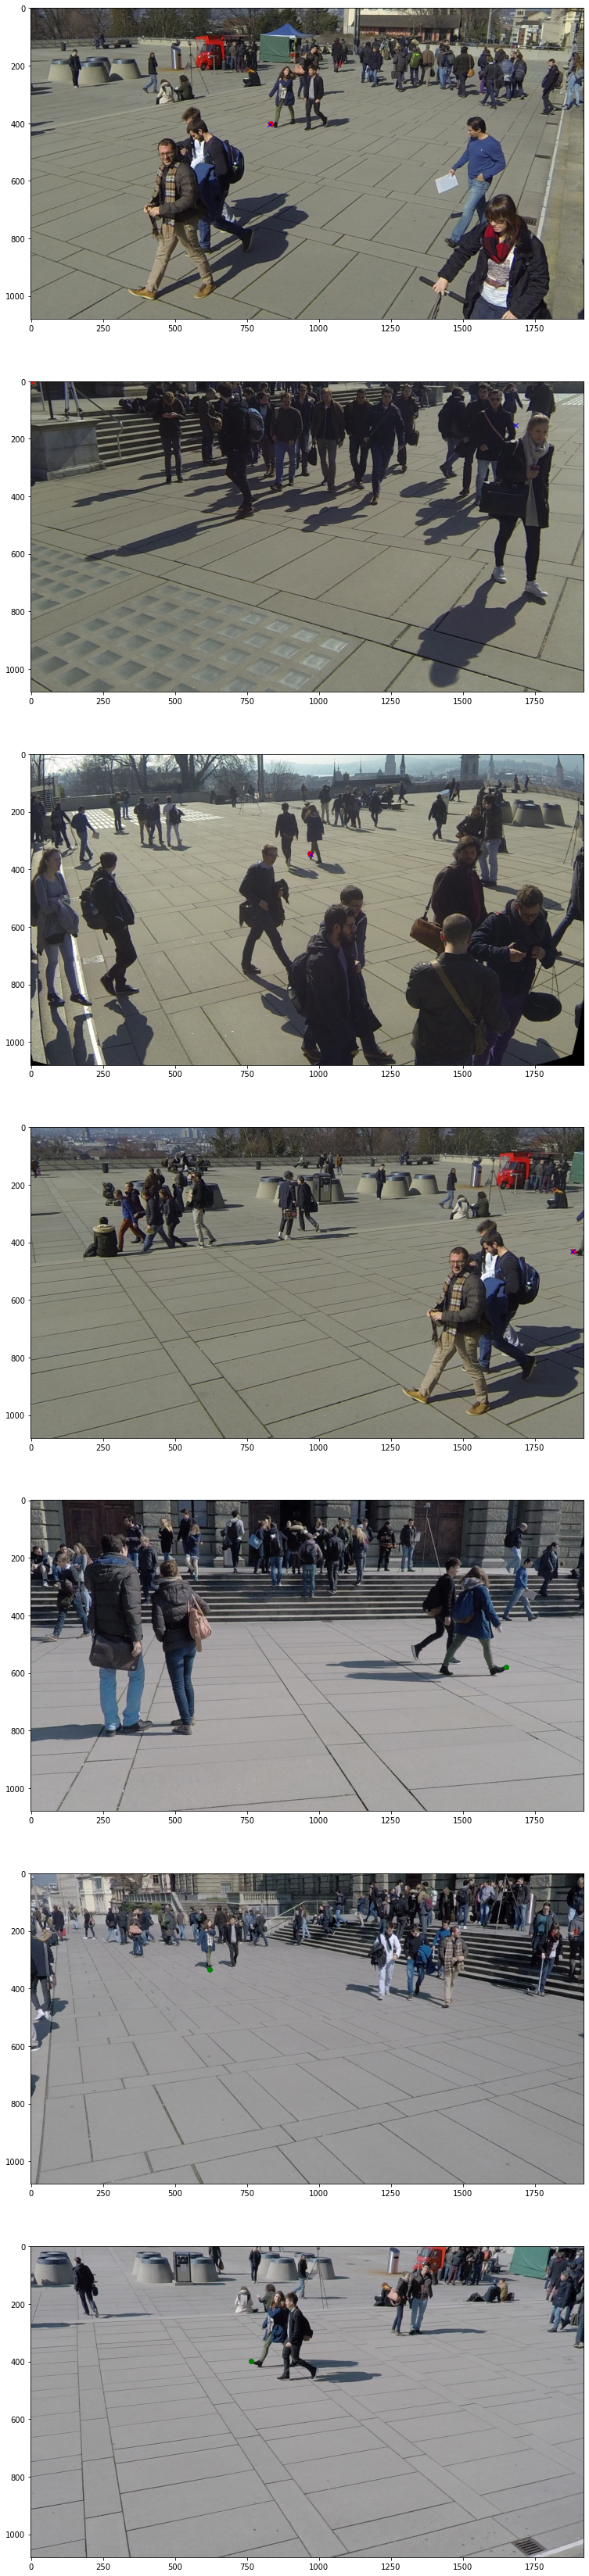

In [ ]:
shoe_tip = np.array([[831, 401], [0, 0], [967, 346], [1882, 432], [1650, 580], [620, 335], [765, 398]])
images = []
P = []
fig, ax = plt.subplots(7, 1)
fig.set_size_inches(20, 60)

# Estimate 3D points using selected cameras
selected_list = [4, 5, 6]

_, shoe_tip_3D = estimate_3D_pt_2D_residual_Gauss_Newton (np.transpose(shoe_tip)[:,selected_list], P_mat[selected_list,:,:])
print('3D shoe tip location: ', shoe_tip_3D.transpose())

reprojected_error = 0.0
count = 0
for i in range(7) :
    file_name = data_dir+'Wildtrack/C{:1d}/00000015.png'.format(i+1)
    image = io.imread(file_name)
    images.append(image)

    ax[i].imshow(images[i], 'gray')
    if (i in selected_list): #images selected to create the estimate
        ax[i].plot(shoe_tip[i, 0], shoe_tip[i, 1], 'go')
        # plot the ground truth the shoe tip in green for images selected to create the estimate
    else : #images NOT selected to create the estimate
        ax[i].plot(shoe_tip[i, 0], shoe_tip[i, 1], 'ro')
        x_shoe = world_to_image (shoe_tip_3D, K_list[i], R_list[i], T_list[i]) # reproject on image
        ax[i].plot(x_shoe[0], x_shoe[1], 'bx') # plot reprjected shoe tip

        # compute reprojected error
        if (i != 1) : # ignore camera 2 for which we do not have shoe tip location
            error = np.linalg.norm(x_shoe.squeeze () - shoe_tip[i,:])
            reprojected_error  = reprojected_error + error
            count = count + 1
            print('\nReprojected shoe tip at {}, actual shoe tip at {}, error: {:3.2f} pixels'.format(x_shoe.squeeze(), shoe_tip[i,:].transpose(), error))

print('\n\nAverage reprojected error: {:3.2f} pixels'.format(reprojected_error/count))


# Assignment - N point depth estimate
All the above was for ONE 3D point. Think about how the equations would change if we have $M$ 3D points to estimate.